In [1]:
# SegFormer-semantic
# ------------------
!pip install -q transformers datasets torchvision pycocotools

In [2]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face


In [4]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import io
import os
import torch
import numpy
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

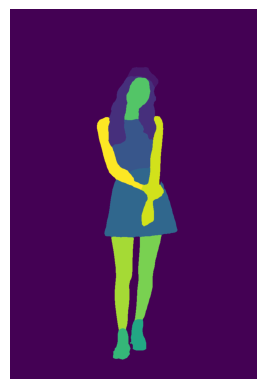

In [ ]:
image_path = "datasets/pose-tests/pose (9).jpg"
image = Image.open(image_path).convert("RGB")

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes", device_map=device)

inputs = processor(images=image, return_tensors="pt").to(device)

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.axis('off')
plt.imshow(pred_seg)
plt.show()

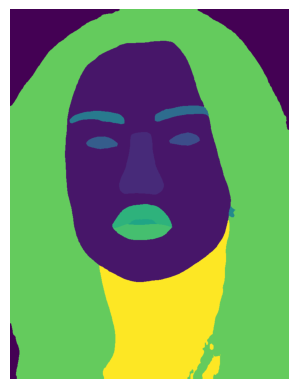

In [ ]:
image_path = "datasets/face-tests/girlface1.jpg"
image = Image.open(image_path).convert("RGB")

device = "cuda" if torch.cuda.is_available() else "cpu"

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # H x W
                mode='bilinear',
                align_corners=False)

# get label masks
labels = upsampled_logits.argmax(dim=1)[0]

# move to CPU to visualize in matplotlib
labels_viz = labels.cpu().numpy()
plt.axis('off')
plt.imshow(labels_viz)
plt.show()

In [5]:
#--- human parsing categories list 18 ---
human_CATEGORIES = [
{"color": [120, 120, 120], "isthing": 0, "id": 0, "name": "Background"},
{"color": [180, 120, 120], "isthing": 0, "id": 1, "name": "Hat"},
{"color": [6, 230, 230], "isthing": 0, "id": 2, "name": "Hair"},
{"color": [80, 50, 50], "isthing": 0, "id": 3, "name": "Sunglasses"},
{"color": [4, 200, 3], "isthing": 0, "id": 4, "name": "Upper-clothes"},
{"color": [140, 190, 214], "isthing": 0, "id": 5, "name": "Skirt"},
{"color": [235, 255, 7], "isthing": 0, "id": 6, "name": "Pants"},
{"color": [204, 5, 255], "isthing": 0, "id": 7, "name": "Dress"},
{"color": [230, 230, 230], "isthing": 0, "id": 8, "name": "Belt"},
{"color": [230, 230, 230], "isthing": 0, "id": 9, "name": "Left-shoe"},
{"color": [224, 5, 255], "isthing": 0, "id": 10, "name": "Right-shoe"},
{"color": [150, 5, 61], "isthing": 0, "id": 11, "name": "Face"},
{"color": [205, 165, 30], "isthing": 0, "id": 12, "name": "Left-leg"},
{"color": [8, 255, 51], "isthing": 0, "id": 13, "name": "Right-leg"},
{"color": [255, 6, 82], "isthing": 0, "id": 14, "name": "Left-arm"},
{"color": [143, 255, 140], "isthing": 0, "id": 15, "name": "Right-arm"},
{"color": [0, 0, 255], "isthing": 0, "id": 16, "name": "Bag"},
{"color": [255, 51, 7], "isthing": 0, "id": 17, "name": "Scarf"},
]

human_BY_ID = {c["id"]: c for c in human_CATEGORIES}

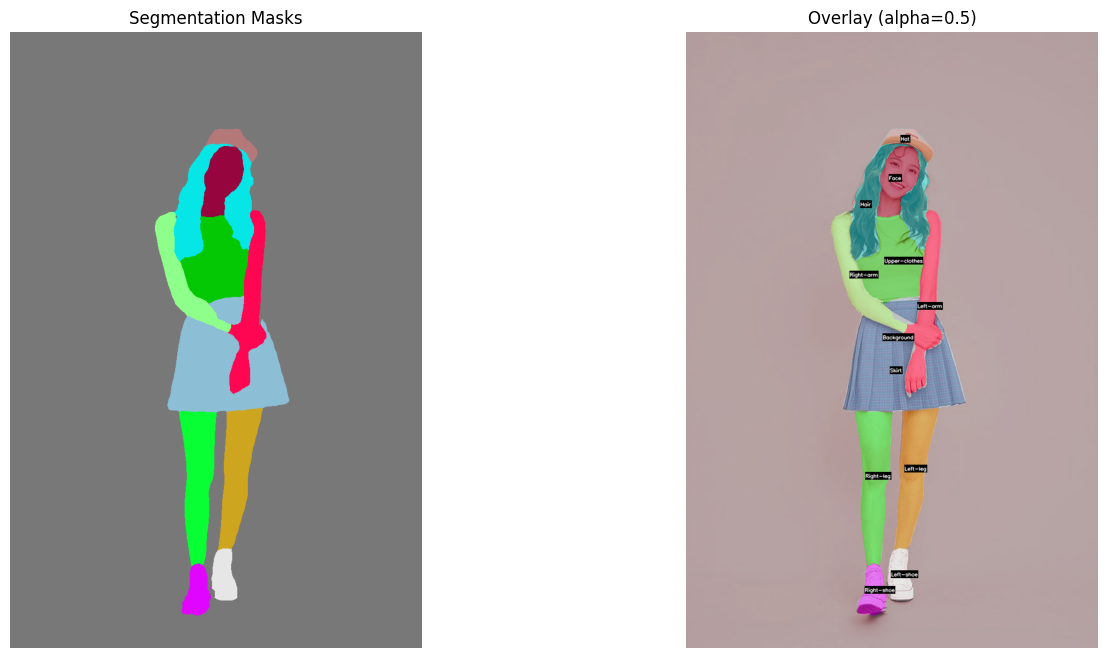

In [ ]:
image_path = "datasets/pose-tests/pose (9).jpg"
image = Image.open(image_path).convert("RGB")

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes", device_map=device)

inputs = processor(images=image, return_tensors="pt").to(device)

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get label masks
pred_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# --- Convert BEiT result into "predicted_map"-like structure ---
predicted_map = {
    "segmentation": torch.tensor(pred_mask),
    "segments_info": []
}

for cid in np.unique(pred_mask):
    if cid not in human_BY_ID:
        continue
    seg_info = {
        "id": int(cid),        # segment id (just class id here, since BEiT is semantic-only)
        "label_id": int(cid),  # same as class id
    }
    predicted_map["segments_info"].append(seg_info)

seg_id = predicted_map["segmentation"].cpu().numpy()

# --- Create color mask ---
color_mask = np.zeros((seg_id.shape[0], seg_id.shape[1], 3), dtype=np.uint8)

for seg_info in predicted_map["segments_info"]:
    segment_id = seg_info["id"]
    label_id = seg_info["label_id"]
    cat = human_BY_ID.get(label_id, None)
    if cat is None:
        continue

    mask = (seg_id == segment_id)

    # Thing: random color per instance
    if cat["isthing"]:
        color = [random.randint(0, 255) for _ in range(3)]
    else:
        # Stuff: fixed color
        color = cat["color"]

    color_mask[mask] = color

# --- Resize and overlay ---
original_np = np.array(image)
H, W = original_np.shape[:2]
color_mask = cv2.resize(color_mask, (W, H), interpolation=cv2.INTER_NEAREST)
id_resized = cv2.resize(seg_id, (W, H), interpolation=cv2.INTER_NEAREST)

alpha = 0.5
overlay_np = cv2.addWeighted(original_np, 1 - alpha, color_mask, alpha, 0)

# --- Draw labels ---
for seg_info in predicted_map["segments_info"]:
    segment_id = seg_info["id"]
    label_id = seg_info["label_id"]
    cat = human_BY_ID.get(label_id, None)
    if cat is None:
        continue
    label_text = cat["name"]

    mask = (id_resized == segment_id).astype(np.uint8)
    if mask.sum() == 0:
        continue

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    largest_idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    cx, cy = centroids[largest_idx]
    cx = int(np.clip(cx, 0, W - 1))
    cy = int(np.clip(cy, 0, H - 1))

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    thickness = 1
    (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
    rect_tl = (cx-15, cy - text_height - baseline)
    rect_br = (cx-15 + text_width, cy + baseline)
    rect_tl = (max(rect_tl[0], 0), max(rect_tl[1], 0))
    rect_br = (min(rect_br[0], W - 1), min(rect_br[1], H - 1))

    cv2.rectangle(overlay_np, rect_tl, rect_br, (0, 0, 0), cv2.FILLED)
    cv2.putText(overlay_np, label_text, (cx-15, cy), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# --- Display ---
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Segmentation Masks')
plt.axis('off')
plt.imshow(color_mask)

plt.subplot(1, 2, 2)
plt.title(f'Overlay (alpha={alpha})')
plt.axis('off')
plt.imshow(overlay_np)
plt.show()

In [ ]:
#--- face parsing categories list 19 ---
face_CATEGORIES = [
{"color": [120, 120, 120], "isthing": 0, "id": 0, "name": "background"},
{"color": [180, 120, 120], "isthing": 0, "id": 1, "name": "skin"},
{"color": [6, 230, 230], "isthing": 0, "id": 2, "name": "nose"},
{"color": [80, 50, 50], "isthing": 0, "id": 3, "name": "eye_g"},
{"color": [4, 200, 3], "isthing": 0, "id": 4, "name": "l_eye"},
{"color": [140, 190, 214], "isthing": 0, "id": 5, "name": "r_eye"},
{"color": [235, 255, 7], "isthing": 0, "id": 6, "name": "l_brow"},
{"color": [204, 5, 255], "isthing": 0, "id": 7, "name": "r_brow"},
{"color": [230, 230, 230], "isthing": 0, "id": 8, "name": "l_ear"},
{"color": [230, 230, 230], "isthing": 0, "id": 9, "name": "r_ear"},
{"color": [224, 5, 255], "isthing": 0, "id": 10, "name": "mouth"},
{"color": [150, 5, 61], "isthing": 0, "id": 11, "name": "u_lip"},
{"color": [150, 5, 61], "isthing": 0, "id": 12, "name": "l_lip"},
{"color": [205, 165, 30], "isthing": 0, "id": 13, "name": "hair"},
{"color": [8, 255, 51], "isthing": 0, "id": 14, "name": "hat"},
{"color": [255, 6, 82], "isthing": 0, "id": 15, "name": "ear_r"},
{"color": [143, 255, 140], "isthing": 0, "id": 16, "name": "neck_l"},
{"color": [204, 255, 4], "isthing": 0, "id": 17, "name": "neck"},
{"color": [255, 51, 7], "isthing": 0, "id": 18, "name": "cloth"},
]

face_BY_ID = {c["id"]: c for c in face_CATEGORIES}

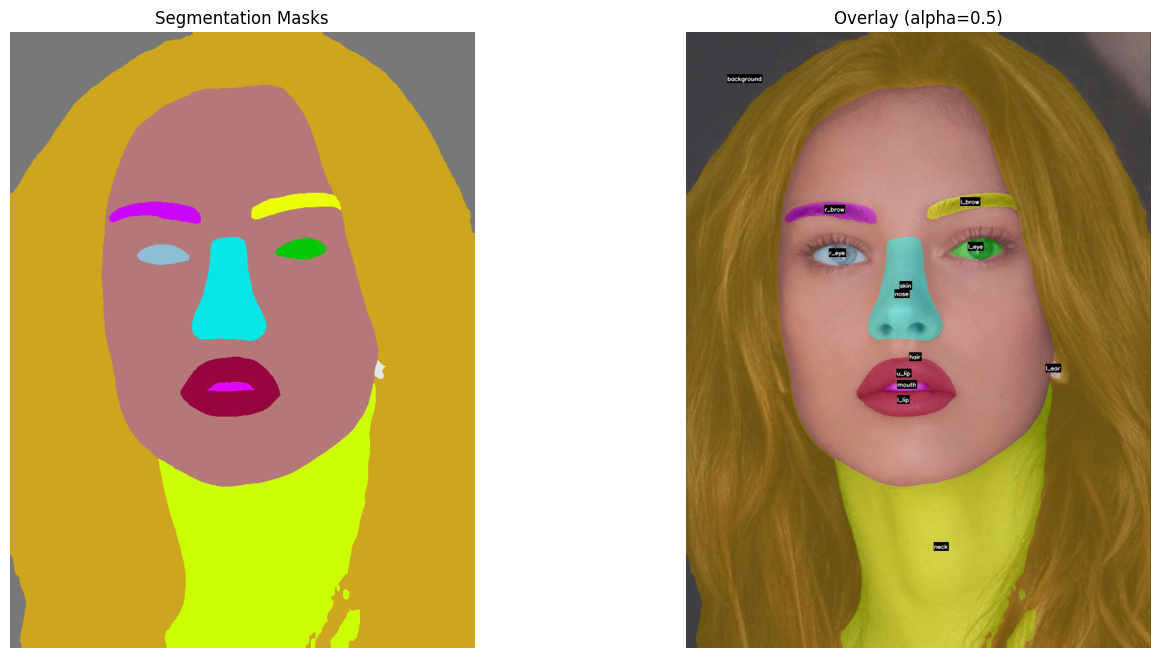

In [ ]:
image_path = "datasets/face-tests/girlface1.jpg"
image = Image.open(image_path).convert("RGB")

device = "cuda" if torch.cuda.is_available() else "cpu"

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # H x W
                mode='bilinear',
                align_corners=False)

# get label masks
pred_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# --- Convert BEiT result into "predicted_map"-like structure ---
predicted_map = {
    "segmentation": torch.tensor(pred_mask),
    "segments_info": []
}

for cid in np.unique(pred_mask):
    if cid not in face_BY_ID:
        continue
    seg_info = {
        "id": int(cid),        # segment id (just class id here, since BEiT is semantic-only)
        "label_id": int(cid),  # same as class id
    }
    predicted_map["segments_info"].append(seg_info)

seg_id = predicted_map["segmentation"].cpu().numpy()

# --- Create color mask ---
color_mask = np.zeros((seg_id.shape[0], seg_id.shape[1], 3), dtype=np.uint8)

for seg_info in predicted_map["segments_info"]:
    segment_id = seg_info["id"]
    label_id = seg_info["label_id"]
    cat = face_BY_ID.get(label_id, None)
    if cat is None:
        continue

    mask = (seg_id == segment_id)

    # Thing: random color per instance
    if cat["isthing"]:
        color = [random.randint(0, 255) for _ in range(3)]
    else:
        # Stuff: fixed color
        color = cat["color"]

    color_mask[mask] = color

# --- Resize and overlay ---
original_np = np.array(image)
H, W = original_np.shape[:2]
color_mask = cv2.resize(color_mask, (W, H), interpolation=cv2.INTER_NEAREST)
id_resized = cv2.resize(seg_id, (W, H), interpolation=cv2.INTER_NEAREST)

alpha = 0.5
overlay_np = cv2.addWeighted(original_np, 1 - alpha, color_mask, alpha, 0)

# --- Draw labels ---
for seg_info in predicted_map["segments_info"]:
    segment_id = seg_info["id"]
    label_id = seg_info["label_id"]
    cat = face_BY_ID.get(label_id, None)
    if cat is None:
        continue
    label_text = cat["name"]

    mask = (id_resized == segment_id).astype(np.uint8)
    if mask.sum() == 0:
        continue

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    largest_idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    cx, cy = centroids[largest_idx]
    cx = int(np.clip(cx, 0, W - 1))
    cy = int(np.clip(cy, 0, H - 1))

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    thickness = 1
    (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
    rect_tl = (cx-15, cy - text_height - baseline)
    rect_br = (cx-15 + text_width, cy + baseline)
    rect_tl = (max(rect_tl[0], 0), max(rect_tl[1], 0))
    rect_br = (min(rect_br[0], W - 1), min(rect_br[1], H - 1))

    cv2.rectangle(overlay_np, rect_tl, rect_br, (0, 0, 0), cv2.FILLED)
    cv2.putText(overlay_np, label_text, (cx-15, cy), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# --- Display ---
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Segmentation Masks')
plt.axis('off')
plt.imshow(color_mask)

plt.subplot(1, 2, 2)
plt.title(f'Overlay (alpha={alpha})')
plt.axis('off')
plt.imshow(overlay_np)
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

With SegFormer_face-parsing,

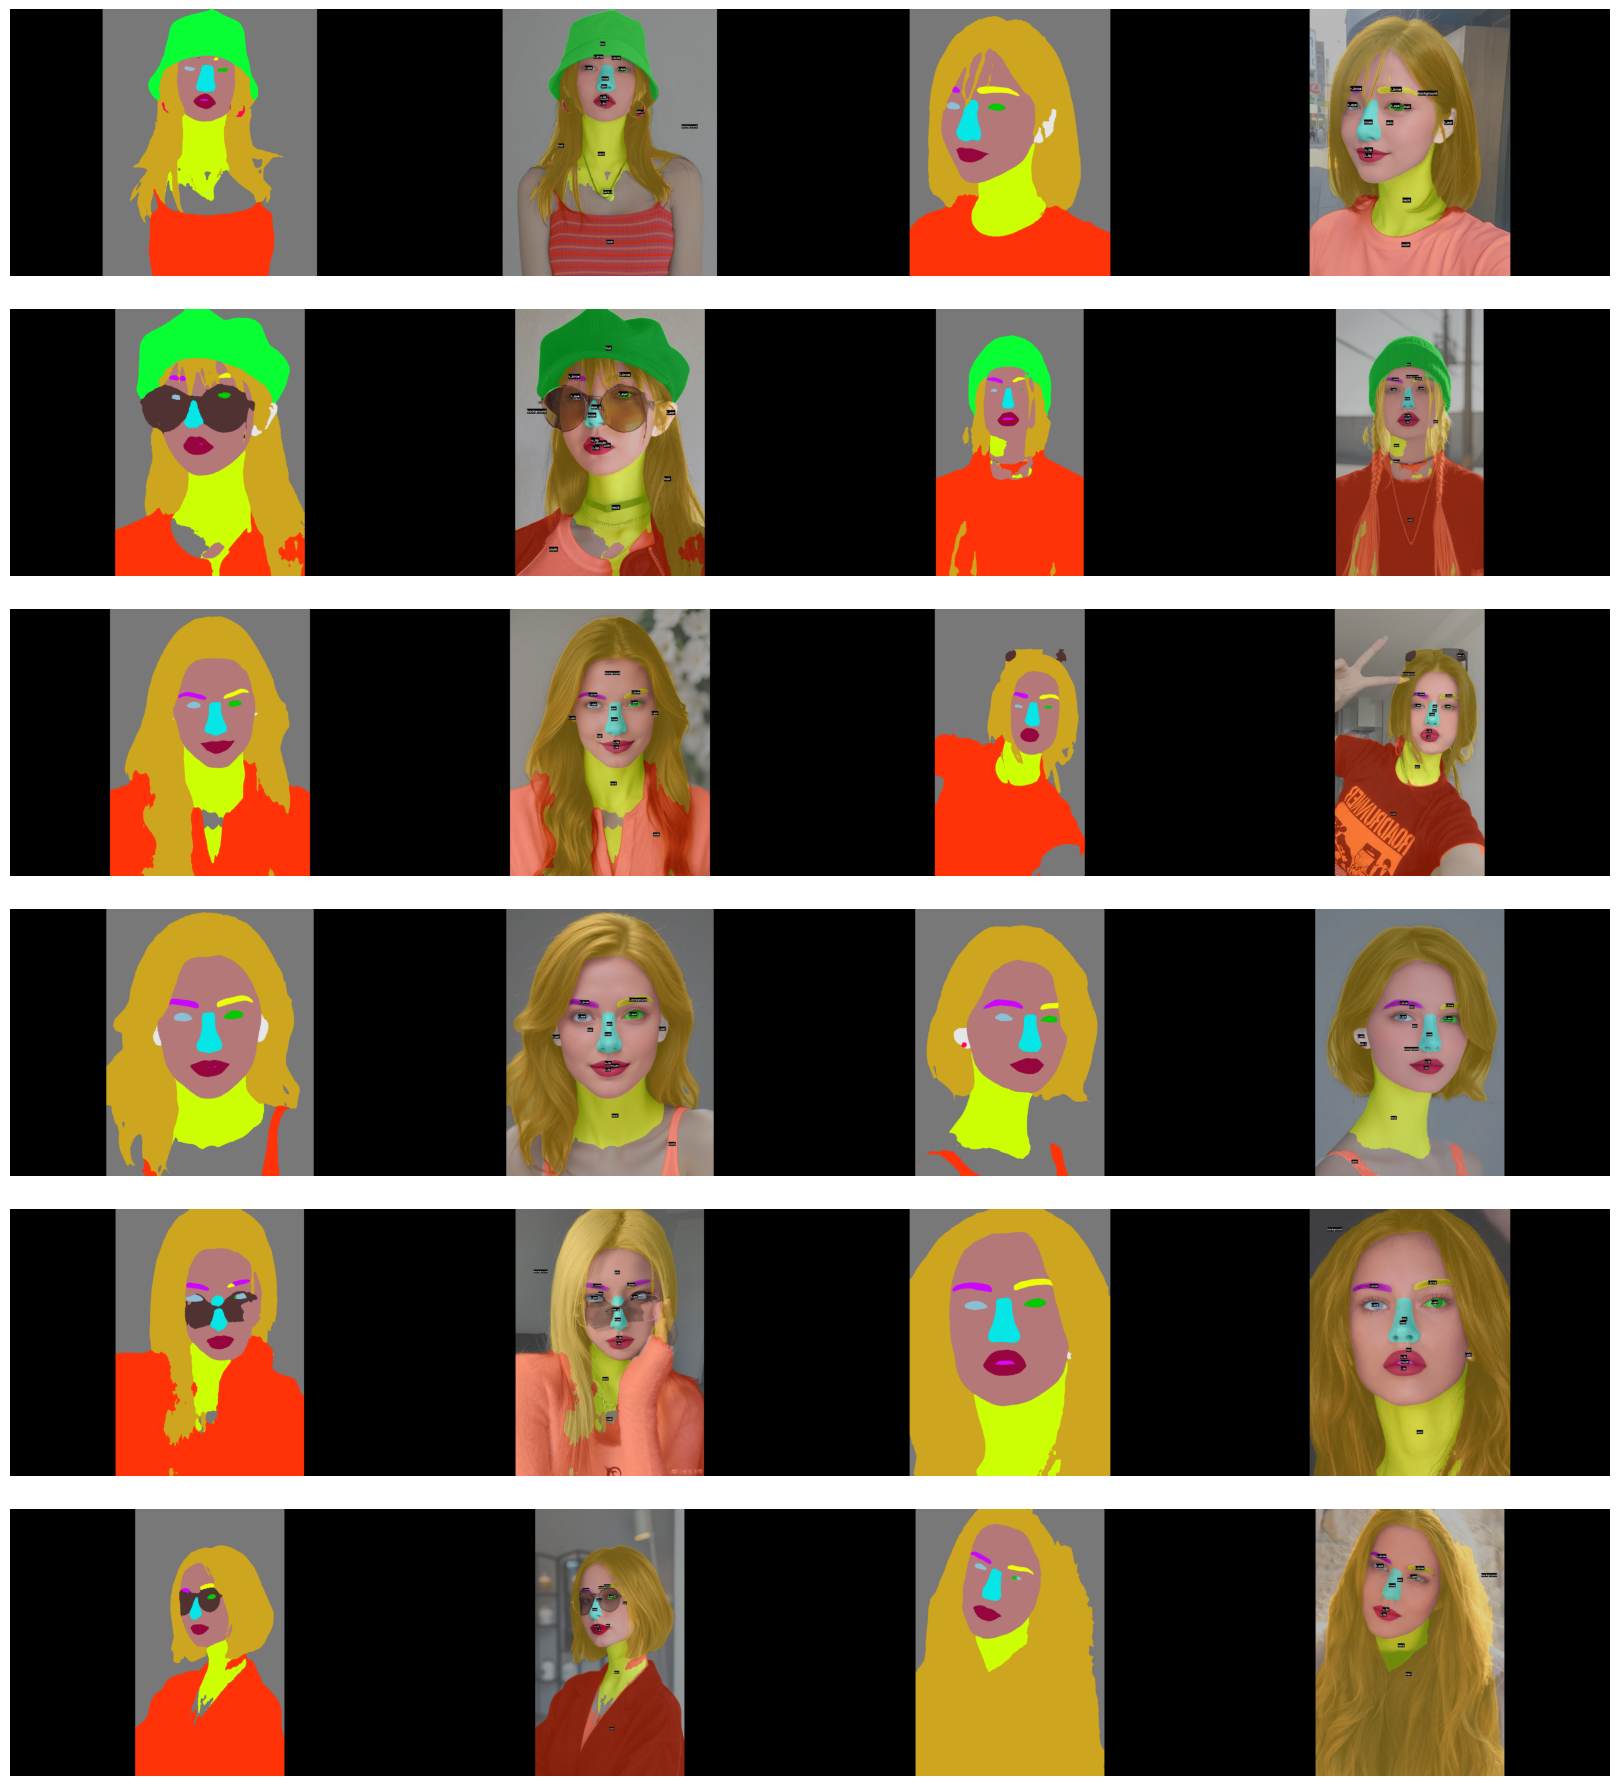

In [ ]:
val_dir = "datasets/face-tests"
num_samples = 12

# --------------------------
# Collect images
# --------------------------
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))
img_paths = [os.path.join(val_dir, fname) for fname in selected_imgs]

processed_imgs = []
img_sizes = []

for image_path in img_paths:
    # Load image
    image = Image.open(image_path).convert("RGB")

    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

    # resize output to match input image dimensions
    upsampled_logits = nn.functional.interpolate(logits,
                    size=image.size[::-1], # H x W
                    mode='bilinear',
                    align_corners=False)

    # get label masks
    pred_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

    # --- Convert BEiT result into "predicted_map"-like structure ---
    predicted_map = {
        "segmentation": torch.tensor(pred_mask),
        "segments_info": []
    }

    for cid in np.unique(pred_mask):
        if cid not in face_BY_ID:
            continue
        seg_info = {
            "id": int(cid),        # segment id (just class id here, since BEiT is semantic-only)
            "label_id": int(cid),  # same as class id
        }
        predicted_map["segments_info"].append(seg_info)

    seg_id = predicted_map["segmentation"].cpu().numpy()

    # --- Create color mask ---
    color_mask = np.zeros((seg_id.shape[0], seg_id.shape[1], 3), dtype=np.uint8)

    for seg_info in predicted_map["segments_info"]:
        segment_id = seg_info["id"]
        label_id = seg_info["label_id"]
        cat = face_BY_ID.get(label_id, None)
        if cat is None:
            continue

        mask = (seg_id == segment_id)

        # Thing: random color per instance
        if cat["isthing"]:
            color = [random.randint(0, 255) for _ in range(3)]
        else:
            # Stuff: fixed color
            color = cat["color"]

        color_mask[mask] = color

    # --- Resize and overlay ---
    original_np = np.array(image)
    H, W = original_np.shape[:2]
    color_mask = cv2.resize(color_mask, (W, H), interpolation=cv2.INTER_NEAREST)
    id_resized = cv2.resize(seg_id, (W, H), interpolation=cv2.INTER_NEAREST)

    alpha = 0.5
    overlay_np = cv2.addWeighted(original_np, 1 - alpha, color_mask, alpha, 0)

    # --- Draw labels ---
    for seg_info in predicted_map["segments_info"]:
        segment_id = seg_info["id"]
        label_id = seg_info["label_id"]
        cat = face_BY_ID.get(label_id, None)
        if cat is None:
            continue
        label_text = cat["name"]

        mask = (id_resized == segment_id).astype(np.uint8)
        if mask.sum() == 0:
            continue

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
        largest_idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        cx, cy = centroids[largest_idx]
        cx = int(np.clip(cx, 0, W - 1))
        cy = int(np.clip(cy, 0, H - 1))

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.3
        thickness = 1
        (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
        rect_tl = (cx-15, cy - text_height - baseline)
        rect_br = (cx-15 + text_width, cy + baseline)
        rect_tl = (max(rect_tl[0], 0), max(rect_tl[1], 0))
        rect_br = (min(rect_br[0], W - 1), min(rect_br[1], H - 1))

        cv2.rectangle(overlay_np, rect_tl, rect_br, (0, 0, 0), cv2.FILLED)
        cv2.putText(overlay_np, label_text, (cx-15, cy), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    processed_imgs.append((color_mask, overlay_np))
    img_sizes.append(overlay_np.shape[:2])  # (height, width)

# --------------------------
# Prepare for grid plot
# --------------------------

cols = 4  # 2 images x 2 visuals = 4 subplots per row
rows = (len(processed_imgs) + 1) // 2  # 2 images per row

plt.figure(figsize=(4 * cols, 3 * rows))

# Target display size for each grid cell
target_height = 720
target_width = 1080

for idx, (img1, img2) in enumerate(processed_imgs):
    for view_idx, view in enumerate([img1, img2]):
        h, w = view.shape[:2]

        # Scale keeping aspect ratio
        scale = min(target_width / w, target_height / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(view, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Pad to target size
        top = (target_height - new_h) // 2
        bottom = target_height - new_h - top
        left = (target_width - new_w) // 2
        right = target_width - new_w - left
        padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

        plot_idx = idx * 2 + view_idx + 1
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(padded)
        plt.axis('off')

plt.tight_layout(pad=0)           # removes padding around the whole figure
plt.subplots_adjust(wspace=0, hspace=0)  # removes spacing between cells
plt.show()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes", device_map=device)

With SegFormer_human-parsing,

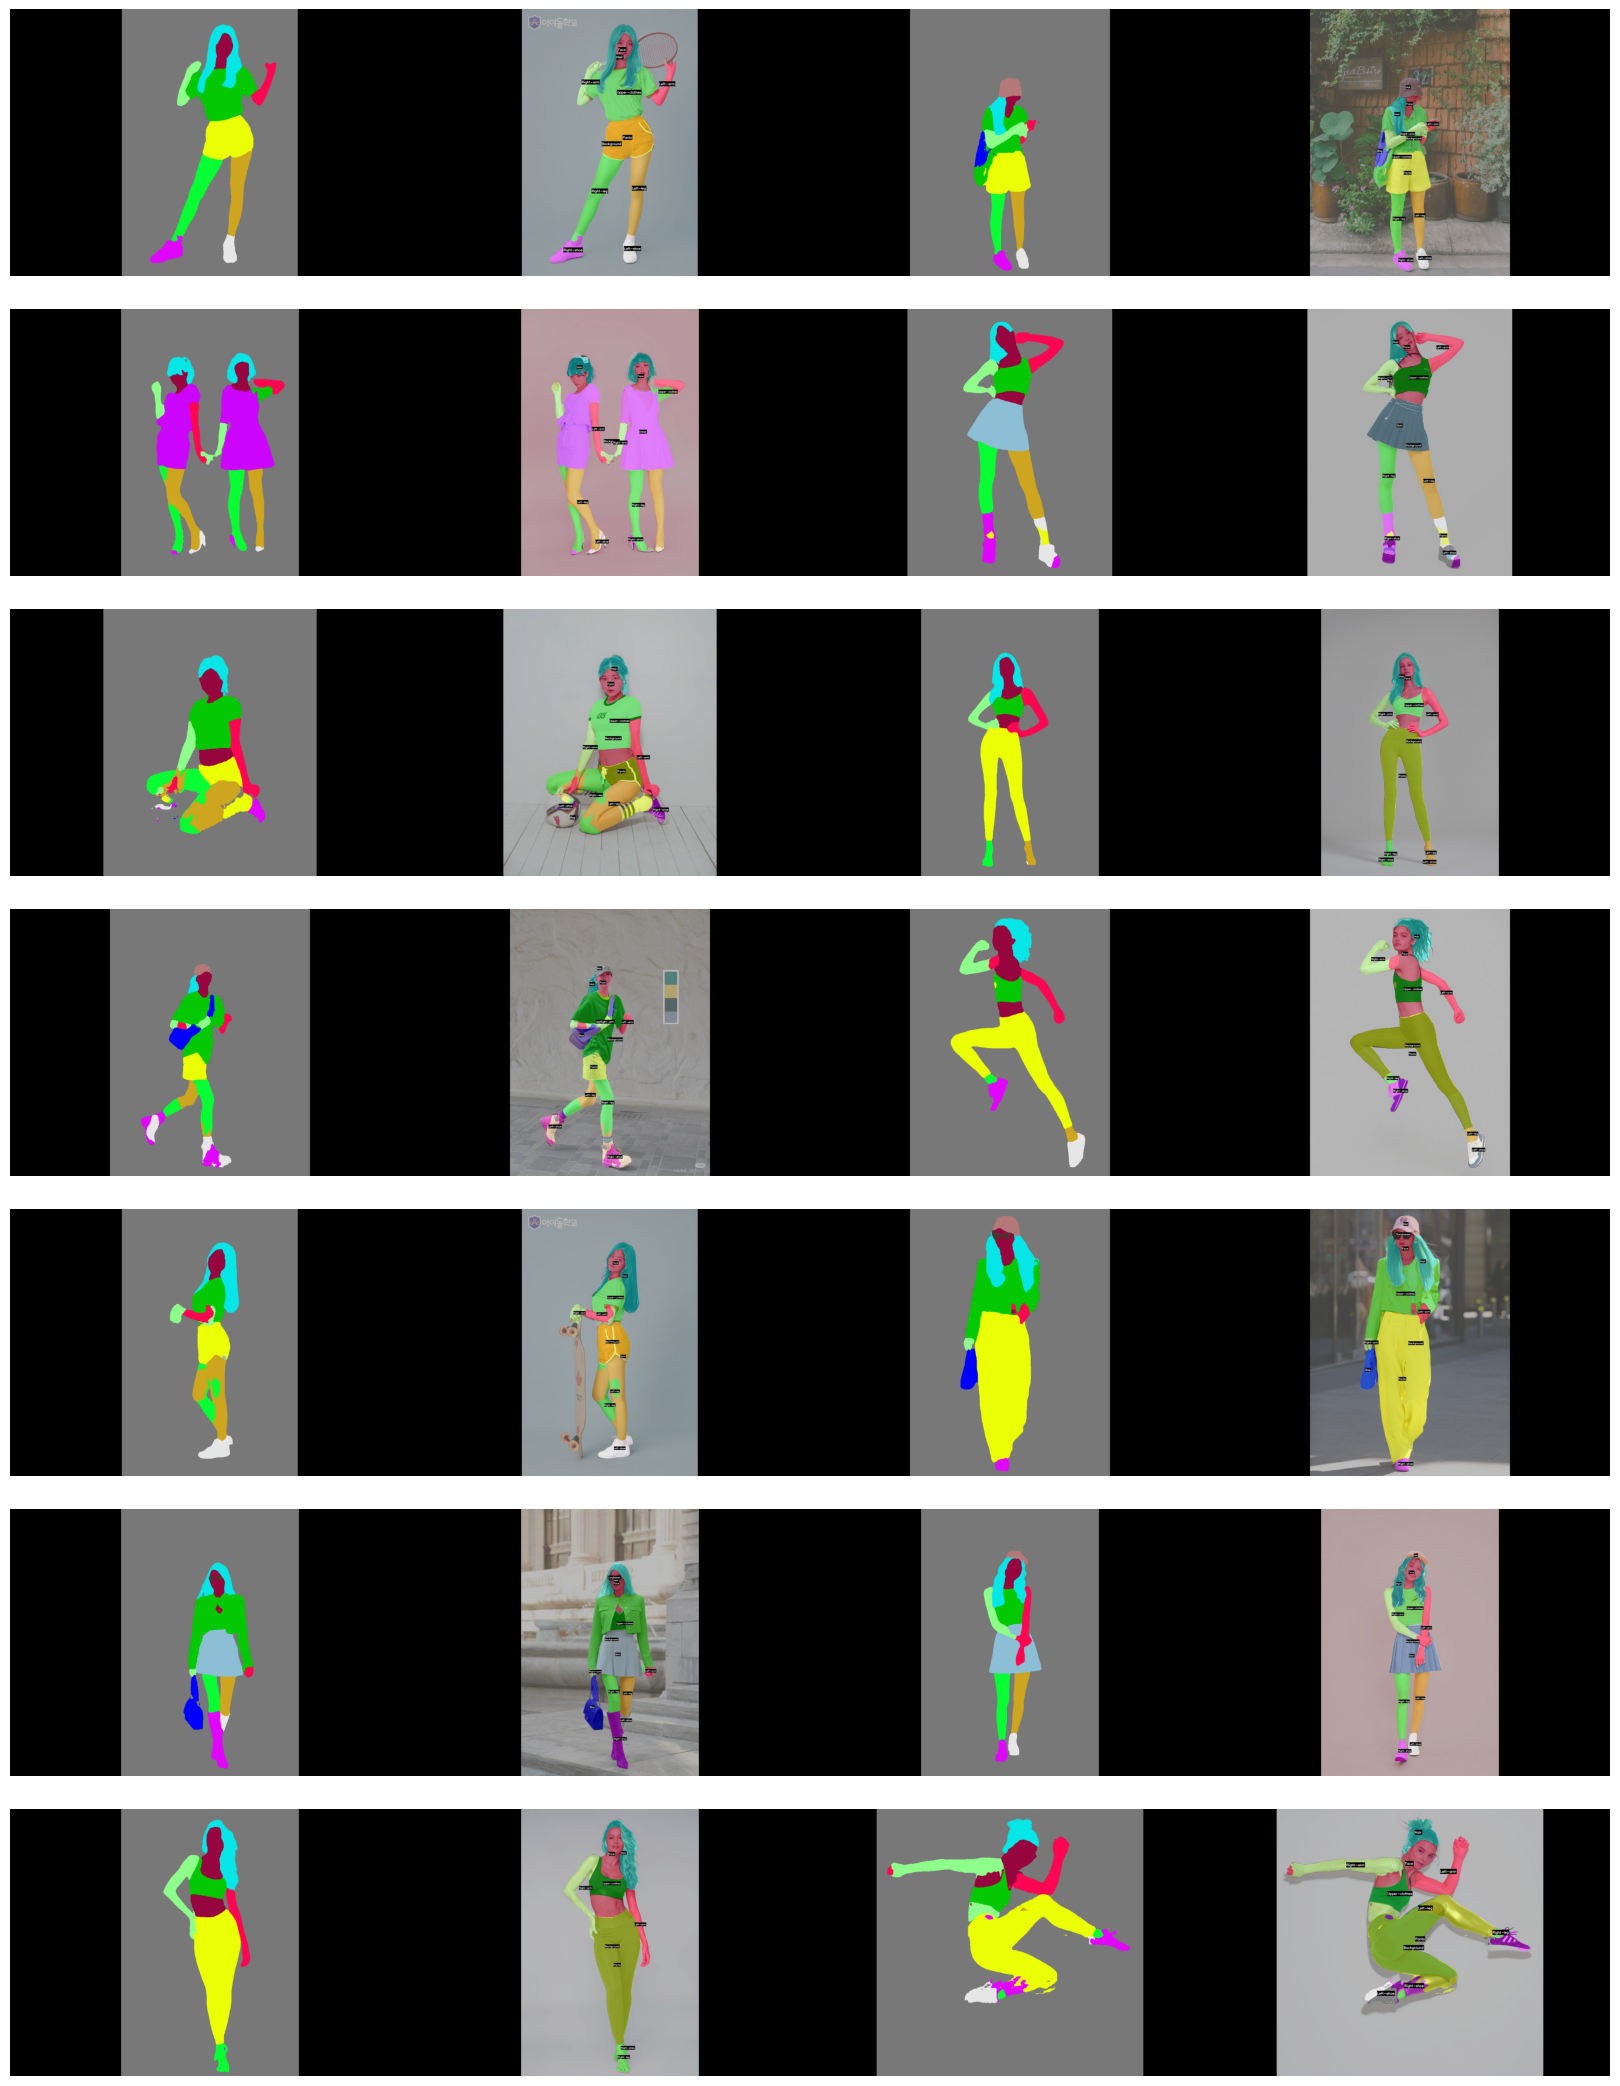

In [8]:
val_dir = "datasets/human-tests"
num_samples = 14

# --------------------------
# Collect images
# --------------------------
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))
img_paths = [os.path.join(val_dir, fname) for fname in selected_imgs]

processed_imgs = []
img_sizes = []

for image_path in img_paths:
    # Load image
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to(device)

    outputs = model(**inputs)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    # get label masks
    pred_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

    # --- Convert BEiT result into "predicted_map"-like structure ---
    predicted_map = {
        "segmentation": torch.tensor(pred_mask),
        "segments_info": []
    }

    for cid in np.unique(pred_mask):
        if cid not in human_BY_ID:
            continue
        seg_info = {
            "id": int(cid),        # segment id (just class id here, since BEiT is semantic-only)
            "label_id": int(cid),  # same as class id
        }
        predicted_map["segments_info"].append(seg_info)

    seg_id = predicted_map["segmentation"].cpu().numpy()

    # --- Create color mask ---
    color_mask = np.zeros((seg_id.shape[0], seg_id.shape[1], 3), dtype=np.uint8)

    for seg_info in predicted_map["segments_info"]:
        segment_id = seg_info["id"]
        label_id = seg_info["label_id"]
        cat = human_BY_ID.get(label_id, None)
        if cat is None:
            continue

        mask = (seg_id == segment_id)

        # Thing: random color per instance
        if cat["isthing"]:
            color = [random.randint(0, 255) for _ in range(3)]
        else:
            # Stuff: fixed color
            color = cat["color"]

        color_mask[mask] = color

    # --- Resize and overlay ---
    original_np = np.array(image)
    H, W = original_np.shape[:2]
    color_mask = cv2.resize(color_mask, (W, H), interpolation=cv2.INTER_NEAREST)
    id_resized = cv2.resize(seg_id, (W, H), interpolation=cv2.INTER_NEAREST)

    alpha = 0.5
    overlay_np = cv2.addWeighted(original_np, 1 - alpha, color_mask, alpha, 0)

    # --- Draw labels ---
    for seg_info in predicted_map["segments_info"]:
        segment_id = seg_info["id"]
        label_id = seg_info["label_id"]
        cat = human_BY_ID.get(label_id, None)
        if cat is None:
            continue
        label_text = cat["name"]

        mask = (id_resized == segment_id).astype(np.uint8)
        if mask.sum() == 0:
            continue

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
        largest_idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        cx, cy = centroids[largest_idx]
        cx = int(np.clip(cx, 0, W - 1))
        cy = int(np.clip(cy, 0, H - 1))

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.3
        thickness = 1
        (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
        rect_tl = (cx-15, cy - text_height - baseline)
        rect_br = (cx-15 + text_width, cy + baseline)
        rect_tl = (max(rect_tl[0], 0), max(rect_tl[1], 0))
        rect_br = (min(rect_br[0], W - 1), min(rect_br[1], H - 1))

        cv2.rectangle(overlay_np, rect_tl, rect_br, (0, 0, 0), cv2.FILLED)
        cv2.putText(overlay_np, label_text, (cx-15, cy), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    processed_imgs.append((color_mask, overlay_np))
    img_sizes.append(overlay_np.shape[:2])  # (height, width)

# --------------------------
# Prepare for grid plot
# --------------------------

cols = 4  # 2 images x 2 visuals = 4 subplots per row
rows = (len(processed_imgs) + 1) // 2  # 2 images per row

plt.figure(figsize=(4 * cols, 3 * rows))

# Target display size for each grid cell
target_height = 720
target_width = 1080

for idx, (img1, img2) in enumerate(processed_imgs):
    for view_idx, view in enumerate([img1, img2]):
        h, w = view.shape[:2]

        # Scale keeping aspect ratio
        scale = min(target_width / w, target_height / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(view, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Pad to target size
        top = (target_height - new_h) // 2
        bottom = target_height - new_h - top
        left = (target_width - new_w) // 2
        right = target_width - new_w - left
        padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

        plot_idx = idx * 2 + view_idx + 1
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(padded)
        plt.axis('off')

plt.tight_layout(pad=0)           # removes padding around the whole figure
plt.subplots_adjust(wspace=0, hspace=0)  # removes spacing between cells
plt.show()